# Method Verification

In this script, the probabilities from the MCWF method is compared against the probabilities from a density matrix simulation to validate the MCWF method as a valid implementation for noisy statevector simulations.

## Import Libraries

In [1]:
from NoisyCircuits import QuantumCircuit as QC
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json

2026-01-15 18:17:25,384	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Initialize the Noise Model

In [2]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum token
backend_name = "ibm_fez"
qpu_type = "heron"
verbose = False

Run the code below to use the latest noise model from IBM hardware calibration data

In [ ]:
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()

Run the code below in case API access is not feasible, and use the sample noise model provided with the software

In [3]:
if qpu_type == "heron":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb"))
elif qpu_type == "eagle":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Eagle_QPU.pkl", "rb"))
else:
    raise ValueError("Unsupported QPU type. Supported types are 'heron' and 'eagle'.")

## Define the Randomized Circuit

Define the function that can generate a randomized circuit that can be executed using density matrix simulation and as an MCWF execution.

In [4]:
def build_random_circuit(circuit, depth, num_qubits):
    circuit.refresh()
    gate = {
        "X" : circuit.X,
        "SX": circuit.SX,
    }
    for _ in range(depth):
        for i in range(num_qubits):
            choice = np.random.choice(["X", "SX"])
            gate[choice](i)
    for i in range(num_qubits-1):
        circuit.CZ(i, i+1)

## Define the Metrics

Define the function that can compute the desired validation metrics between the reference probability distribution (from the density matrix) and the probability distribution from the MCWF method. The chosen metrics are:

1. **Battacharyya Coefficient:** Defines the overlap between two probability distributions and is bounded between $[0,1]$, where a value of $1$ indicates a similar distributions. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
BC(p,q) = \sum_{i=1}^{N} \sqrt{p_iq_i}
\end{equation*}
Interpretation: The closer the two distributions are in similarity, the closer value of the Battacharyya Coefficient is to $1$.

2. **Battacharyya Distance:** Provides a distance measure that indicates the dissimilarity between two probability distributions and lies between $[0, \infty]$, where a value of $0$ indicates a similar distribution and higher the value, the greater the dissimilarity between the two distributions. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
BD(p,q) = -\text{log}(BC(p,q))
\end{equation*}

3. **Hellinger Distance:** Provides a measure of the geometric difference between two probability distributions and is bounded between $[0,1]$, where a value of $0$ indicates a similar distribution. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
HD(p,q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^{N}(\sqrt{p_i} - \sqrt{q_i})^2}
\end{equation*}

4. **Jenson-Shannon (JS) Divergence:** It is the smoothed, symmetric version of the KL divergence, measuring the average information divergence between the two distributions and is bounded between $[0, \text{log}(2)]$ where lower the value the lesser the information loss. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
JSD(p||q) = \frac{1}{2}(KL(p||m) + KL(q||m)) \text{ with } m = \frac{p+q}{2}
\end{equation*}

\begin{equation*}
KL(a||b) = \sum_{i=1}^{N}a_i\text{log}(\frac{a_i}{b_i})
\end{equation*}

In [5]:
def compute_metrics(pd_1, pd_2):
    battacharyya_coefficient = np.sum(np.sqrt(pd_1 * pd_2))
    battacharyya_distance = -np.log(battacharyya_coefficient)
    hellinger_distance = np.sqrt(np.sum((np.sqrt(pd_1) - np.sqrt(pd_2))**2)) / np.sqrt(2)
    m = 0.5 * (pd_1 + pd_2)
    js = 0.5 * np.sum(pd_1 * np.log(1e-10 + pd_1 / m) + pd_2 * np.log(1e-10 + pd_2 / m))
    return (battacharyya_coefficient, battacharyya_distance, hellinger_distance, js)

## Define Randomized Test Parameters

Define the range for the number of qubits to use and the total number of single qubit gates per qubit. Note that an entanglement gate is applied to after each single qubit gate (recommended to start with 2 qubits).

In [6]:
qubit_list = [2, 3, 4, 5, 6, 7]
depth_list = [5, 20, 50, 100]

## Perform the Verification with the Randomized Circuits

In [7]:
metrics_identifier = ("Battacharyya Coefficient", "Battacharyya Distance", "Hellinger Distance", "Jensen-Shannon Divergence")
mcwf_10t_results = {}
mcwf_100t_results = {}
mcwf_200t_results = {}
mcwf_500t_results = {}
mcwf_1000t_results = {}

In [8]:
log = open("Results_Log_File_Qiskit.txt", "w")
for num_qubits in qubit_list:
    circ = QC(num_qubits=num_qubits, 
              noise_model=noise_model,
              backend_qpu_type=qpu_type, 
              num_trajectories=1, 
              sim_backend = "qiskit",
              num_cores=50, 
              threshold=1e-8, 
              jsonize=True,
              verbose=verbose)
    for depth in depth_list:
        circ.refresh()
        log.write("===========================================================================\n")
        log.write(f"Running Circuit with {num_qubits} qubits and depth {depth}\n")
        build_random_circuit(circ, depth, num_qubits)
        probs_density_matrix = circ.run_with_density_matrix(list(range(num_qubits)))
        probs_mcwf_10t = circ.execute(list(range(num_qubits)), num_trajectories=10)
        probs_mcwf_100t = circ.execute(list(range(num_qubits)), num_trajectories=100)
        probs_mcwf_200t = circ.execute(list(range(num_qubits)), num_trajectories=200)
        probs_mcwf_500t = circ.execute(list(range(num_qubits)), num_trajectories=500)
        probs_mcwf_1000t = circ.execute(list(range(num_qubits)), num_trajectories=1000)
        metrics_10t = compute_metrics(probs_density_matrix, probs_mcwf_10t)
        metrics_100t = compute_metrics(probs_density_matrix, probs_mcwf_100t)
        metrics_200t = compute_metrics(probs_density_matrix, probs_mcwf_200t)
        metrics_500t = compute_metrics(probs_density_matrix, probs_mcwf_500t)
        metrics_1000t = compute_metrics(probs_density_matrix, probs_mcwf_1000t)
        key = (num_qubits, depth)
        mcwf_10t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_10t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_100t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_100t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_200t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_200t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_500t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_500t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_1000t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_1000t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        log.write(f"Metrics for MCWF with {10} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_10t[i]}\n")
        log.write(f"Metrics for MCWF with {100} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_100t[i]}\n")
        log.write(f"Metrics for MCWF with {200} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_200t[i]}\n")
        log.write(f"Metrics for MCWF with {500} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_500t[i]}\n")
        log.write(f"Metrics for MCWF with {1000} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_1000t[i]}\n")
        log.write("===========================================================================\n\n")
        log.flush()
    circ.shutdown()

Successfully switched backend to qiskit.


2026-01-15 17:15:16,319	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 17:16:35,991	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 17:18:29,800	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 17:20:54,991	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 17:23:58,267	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 17:27:37,518	INFO worker.py:1927 -- Started a local Ray instance.


## Visualize the Results

Plot the result data for simple visualization

In [8]:
def plot_metrics(dict_list, trajectory_list):
    depths = depth_list
    qubits = qubit_list
    
    for depth in depths:
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        for i, metric in enumerate(metrics_identifier):
            for traj_idx, traj_count in enumerate(trajectory_list):
                metric_values = []
                for num_qubits in qubits:
                    key = (num_qubits, depth)
                    if key in dict_list[traj_idx]:
                        metric_values.append(dict_list[traj_idx][key][metric])
                    else:
                        metric_values.append(0)
                ax[i//2, i%2].plot(qubits, metric_values, label=f"Trajectories: {traj_count}", marker='o')
            
            ax[i//2, i%2].set_title(f"{metric}")
            ax[i//2, i%2].set_xlabel("Number of Qubits")
            ax[i//2, i%2].set_xticks(qubits)
            ax[i//2, i%2].set_ylabel(metric)
            ax[i//2, i%2].legend()
            ax[i//2, i%2].grid()
        plt.suptitle(f"Comparison for Depth={depth}", fontsize=16)   
        plt.tight_layout()
        plt.show()

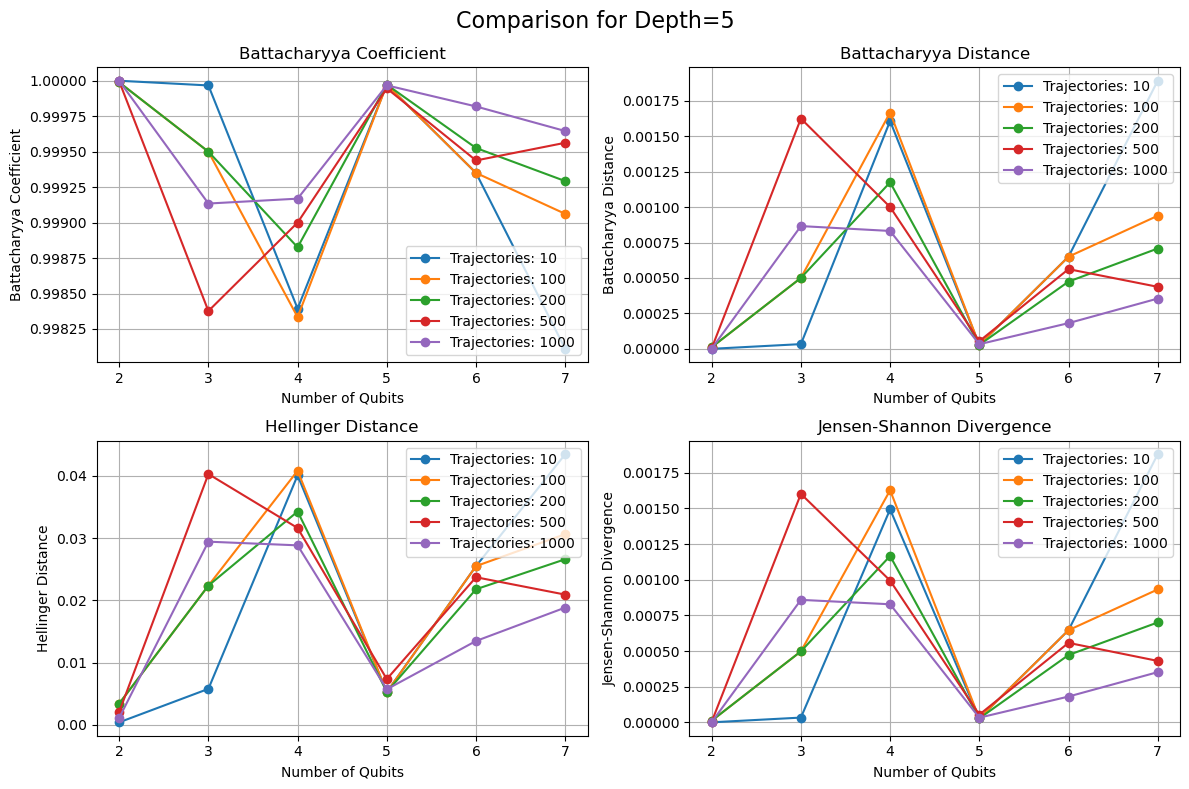

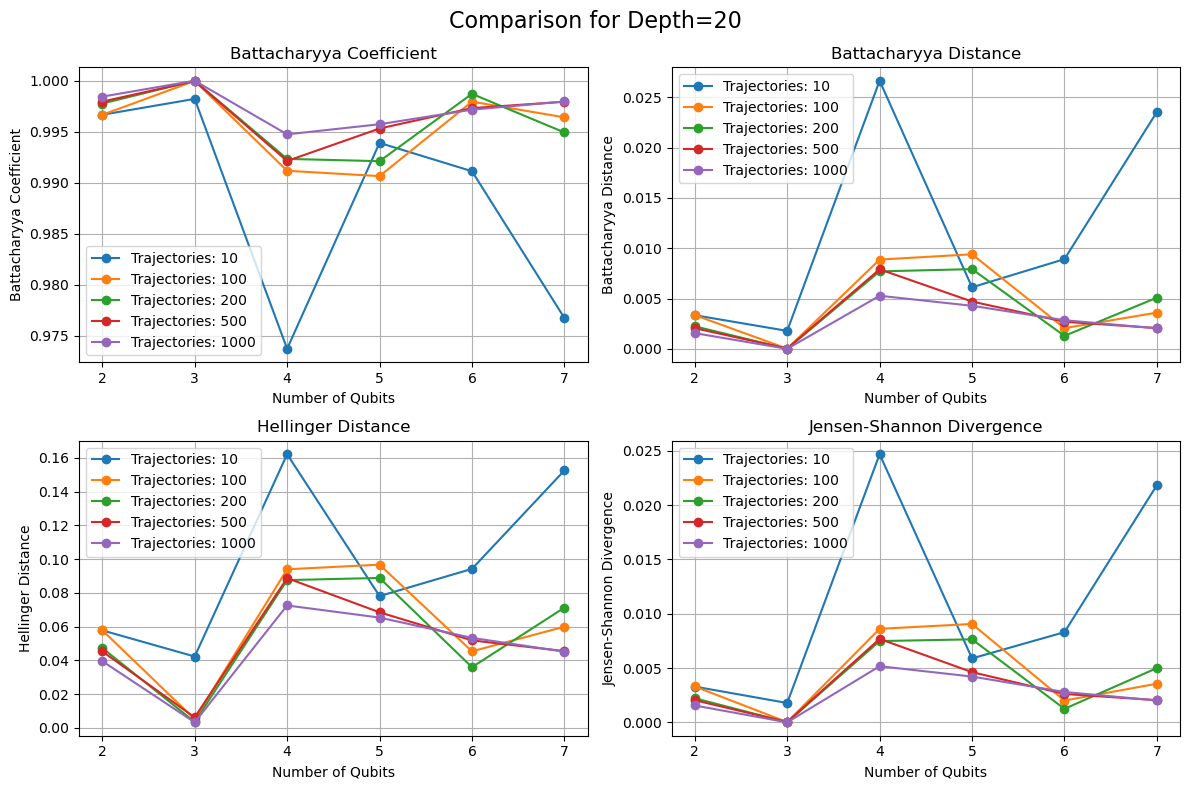

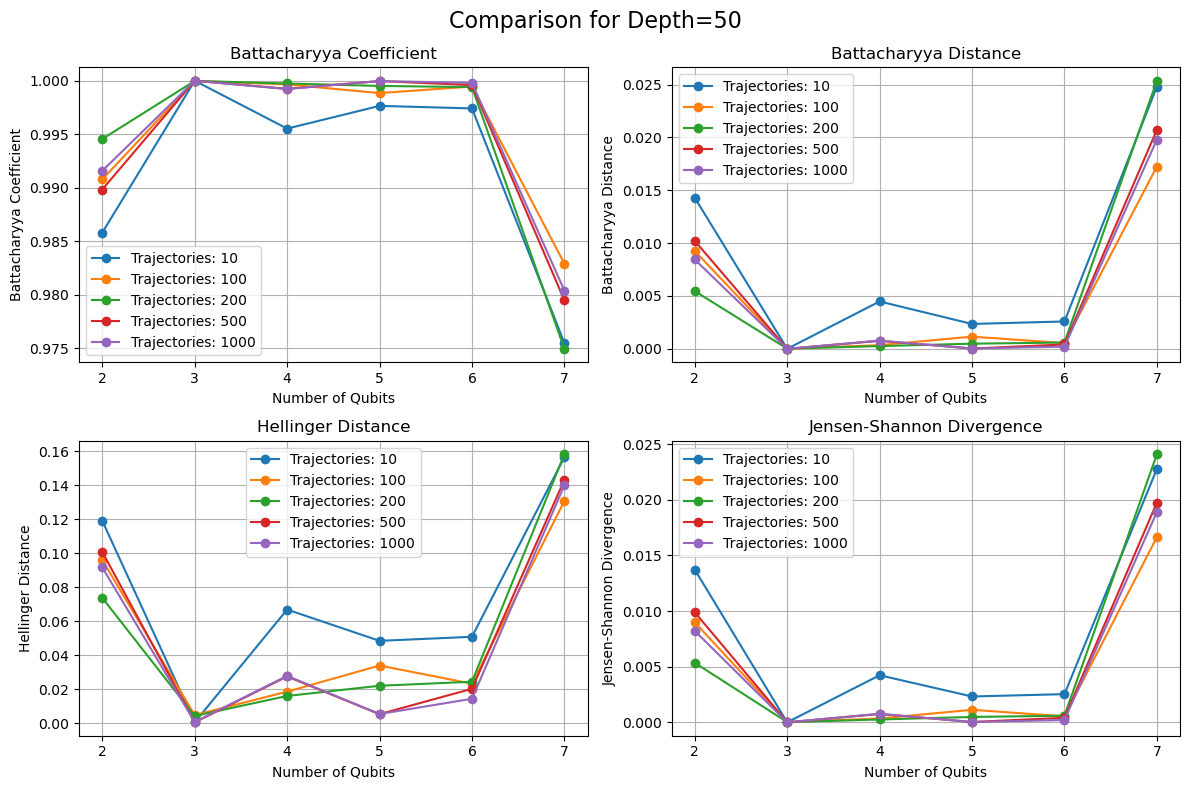

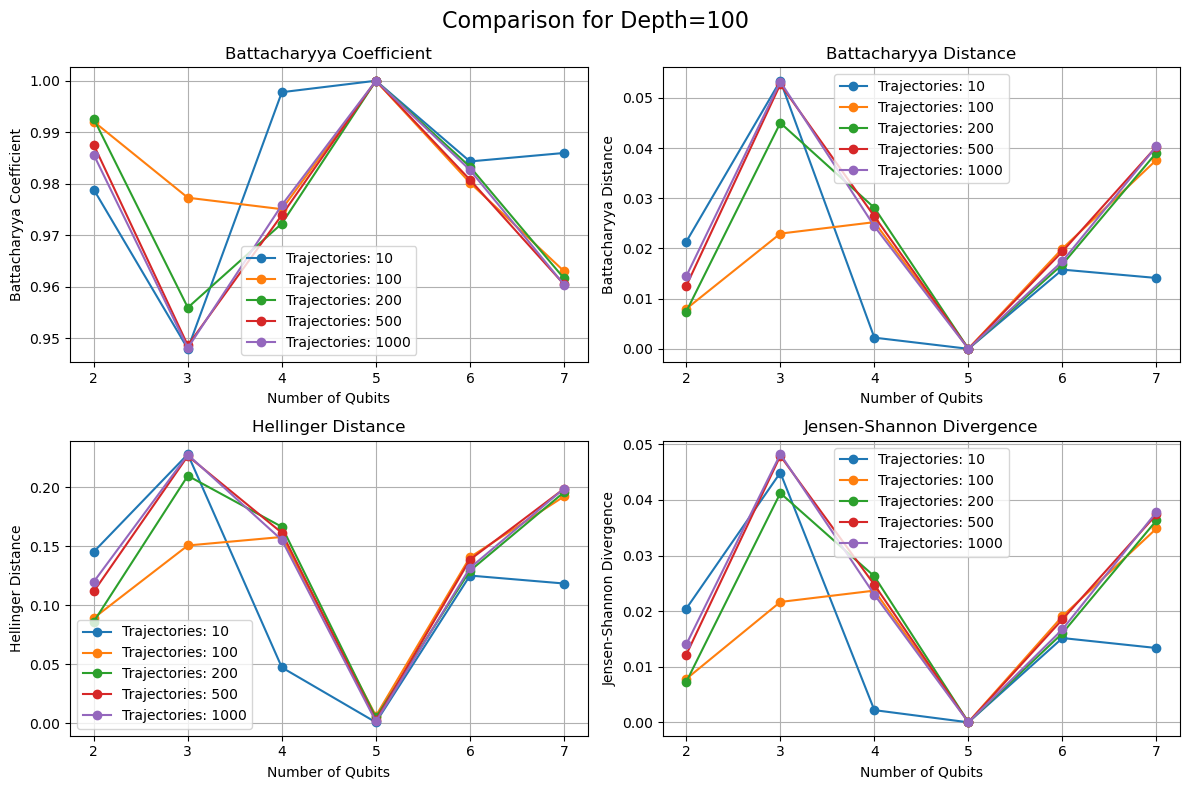

In [10]:
plot_metrics([mcwf_10t_results, mcwf_100t_results, mcwf_200t_results, mcwf_500t_results, mcwf_1000t_results], [10, 100, 200, 500, 1000])

In [9]:
log = open("Results_Log_File_Pennylane.txt", "w")
for num_qubits in qubit_list:
    circ = QC(num_qubits=num_qubits, 
              noise_model=noise_model,
              backend_qpu_type=qpu_type, 
              num_trajectories=1, 
              sim_backend = "pennylane",
              num_cores=50, 
              threshold=1e-8, 
              jsonize=True,
              verbose=verbose)
    for depth in depth_list:
        circ.refresh()
        log.write("===========================================================================\n")
        log.write(f"Running Circuit with {num_qubits} qubits and depth {depth}\n")
        build_random_circuit(circ, depth, num_qubits)
        probs_density_matrix = circ.run_with_density_matrix(list(range(num_qubits)))
        probs_mcwf_10t = circ.execute(list(range(num_qubits)), num_trajectories=10)
        probs_mcwf_100t = circ.execute(list(range(num_qubits)), num_trajectories=100)
        probs_mcwf_200t = circ.execute(list(range(num_qubits)), num_trajectories=200)
        probs_mcwf_500t = circ.execute(list(range(num_qubits)), num_trajectories=500)
        probs_mcwf_1000t = circ.execute(list(range(num_qubits)), num_trajectories=1000)
        metrics_10t = compute_metrics(probs_density_matrix, probs_mcwf_10t)
        metrics_100t = compute_metrics(probs_density_matrix, probs_mcwf_100t)
        metrics_200t = compute_metrics(probs_density_matrix, probs_mcwf_200t)
        metrics_500t = compute_metrics(probs_density_matrix, probs_mcwf_500t)
        metrics_1000t = compute_metrics(probs_density_matrix, probs_mcwf_1000t)
        key = (num_qubits, depth)
        mcwf_10t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_10t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_100t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_100t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_200t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_200t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_500t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_500t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        mcwf_1000t_results[key] = dict(
            [("num_qubits", num_qubits), ("depth", depth)] +
            [(metric, metrics_1000t[i]) for i, metric in enumerate(metrics_identifier)]
        )
        log.write(f"Metrics for MCWF with {10} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_10t[i]}\n")
        log.write(f"Metrics for MCWF with {100} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_100t[i]}\n")
        log.write(f"Metrics for MCWF with {200} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_200t[i]}\n")
        log.write(f"Metrics for MCWF with {500} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_500t[i]}\n")
        log.write(f"Metrics for MCWF with {1000} Trajectories:\n")
        for i in range(len(metrics_identifier)):
            log.write(f"{metrics_identifier[i]}: {metrics_1000t[i]}\n")
        log.write("===========================================================================\n\n")
        log.flush()
    circ.shutdown()

Successfully switched backend to pennylane.


2026-01-15 18:17:56,345	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to pennylane.


2026-01-15 18:18:41,471	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to pennylane.


2026-01-15 18:19:39,658	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to pennylane.


2026-01-15 18:20:52,834	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to pennylane.


2026-01-15 18:22:19,666	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to pennylane.


2026-01-15 18:24:05,301	INFO worker.py:1927 -- Started a local Ray instance.


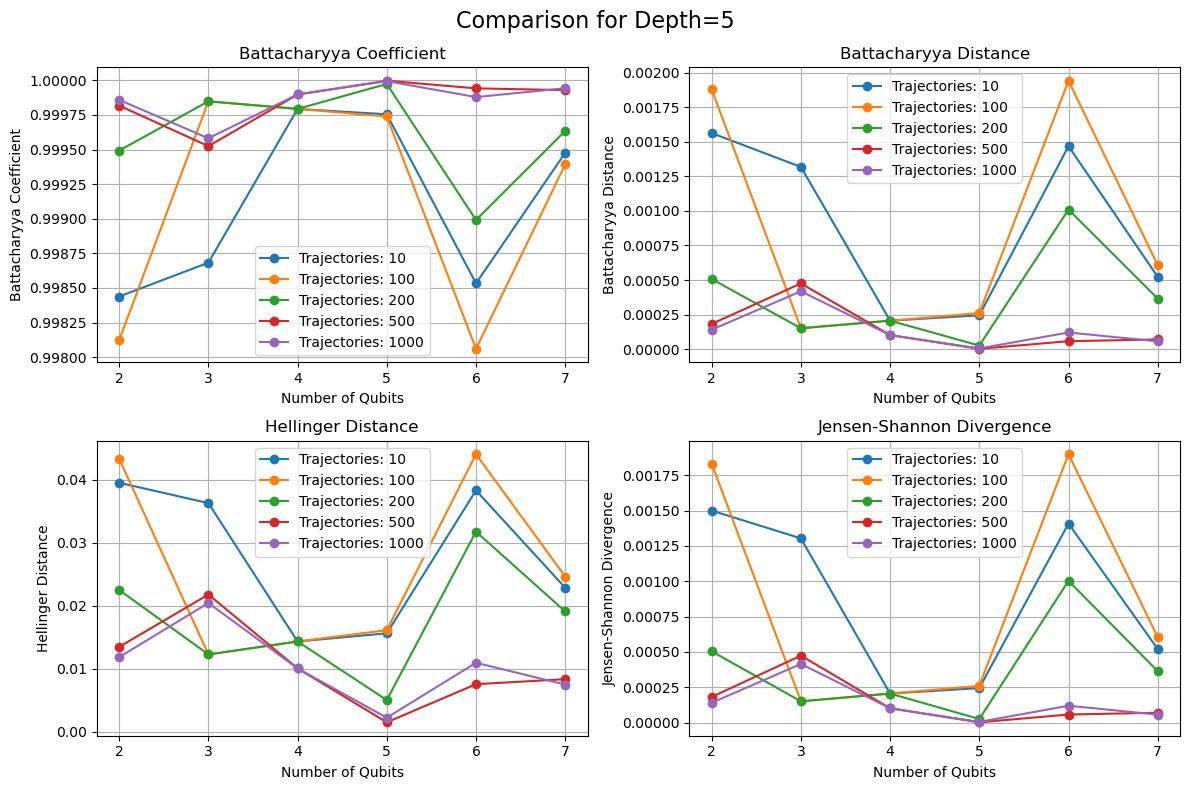

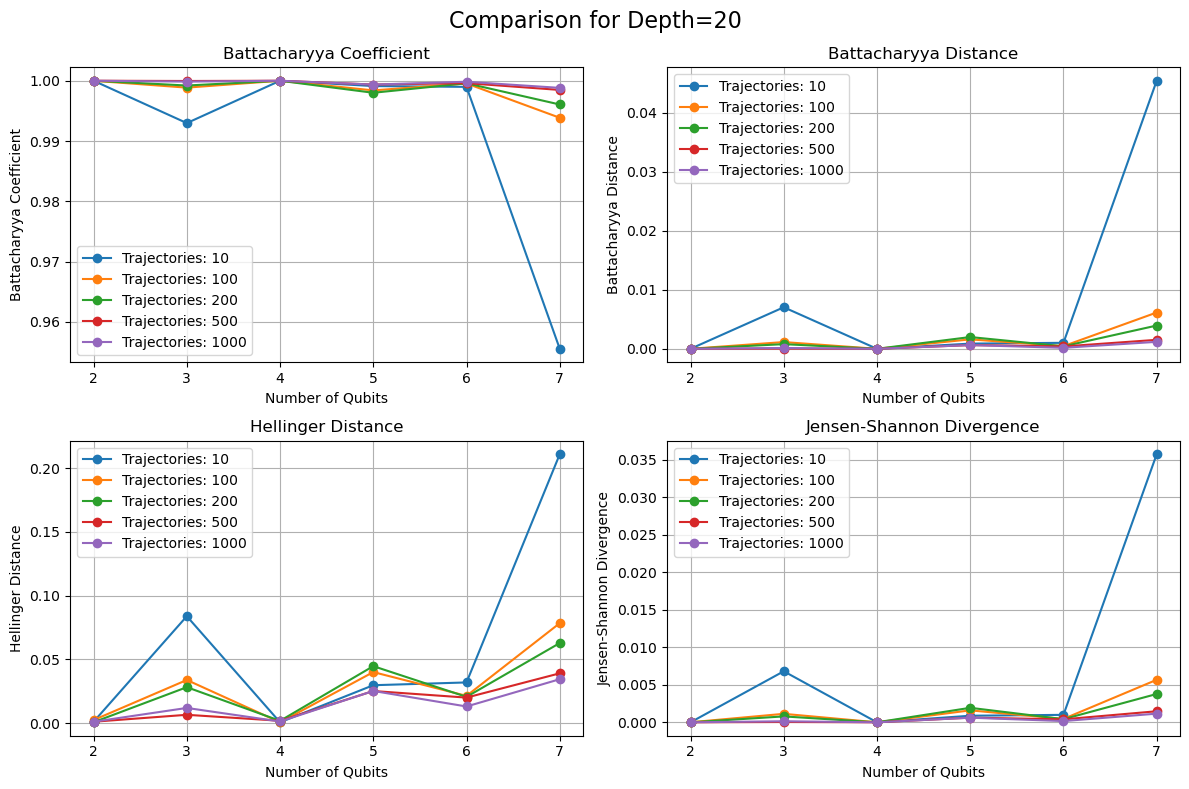

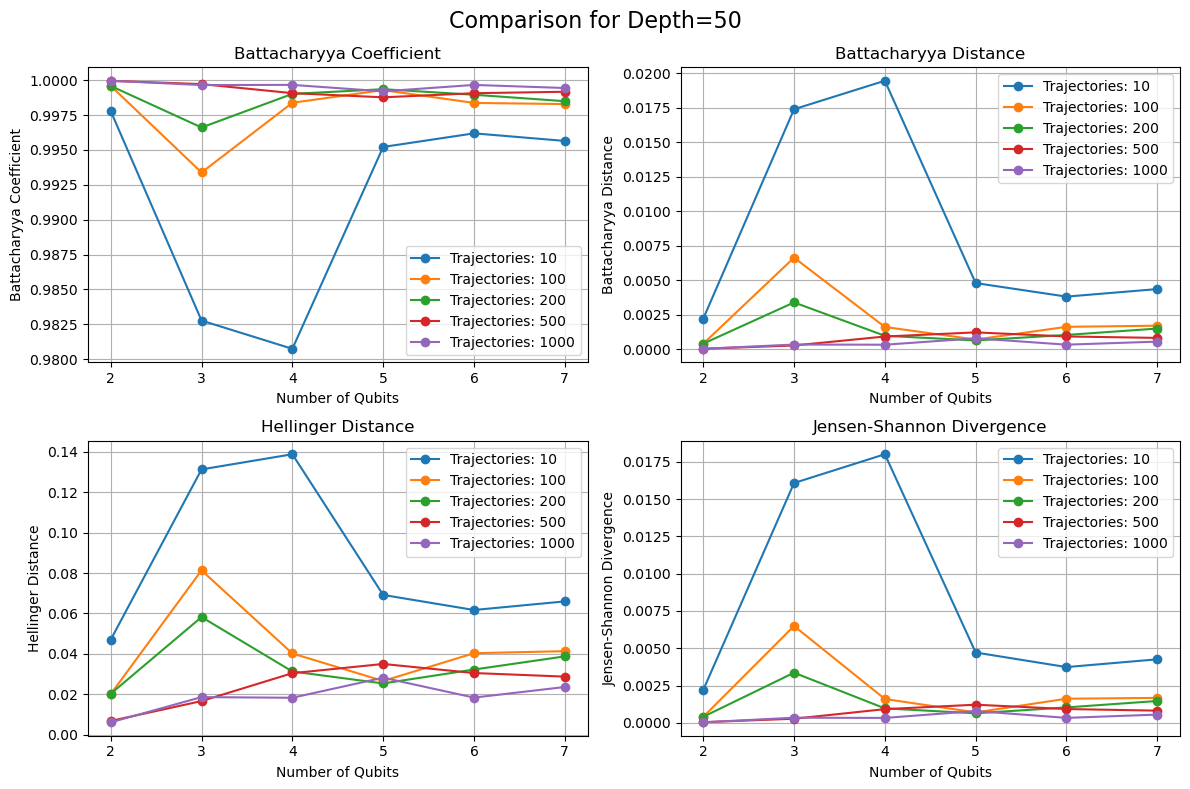

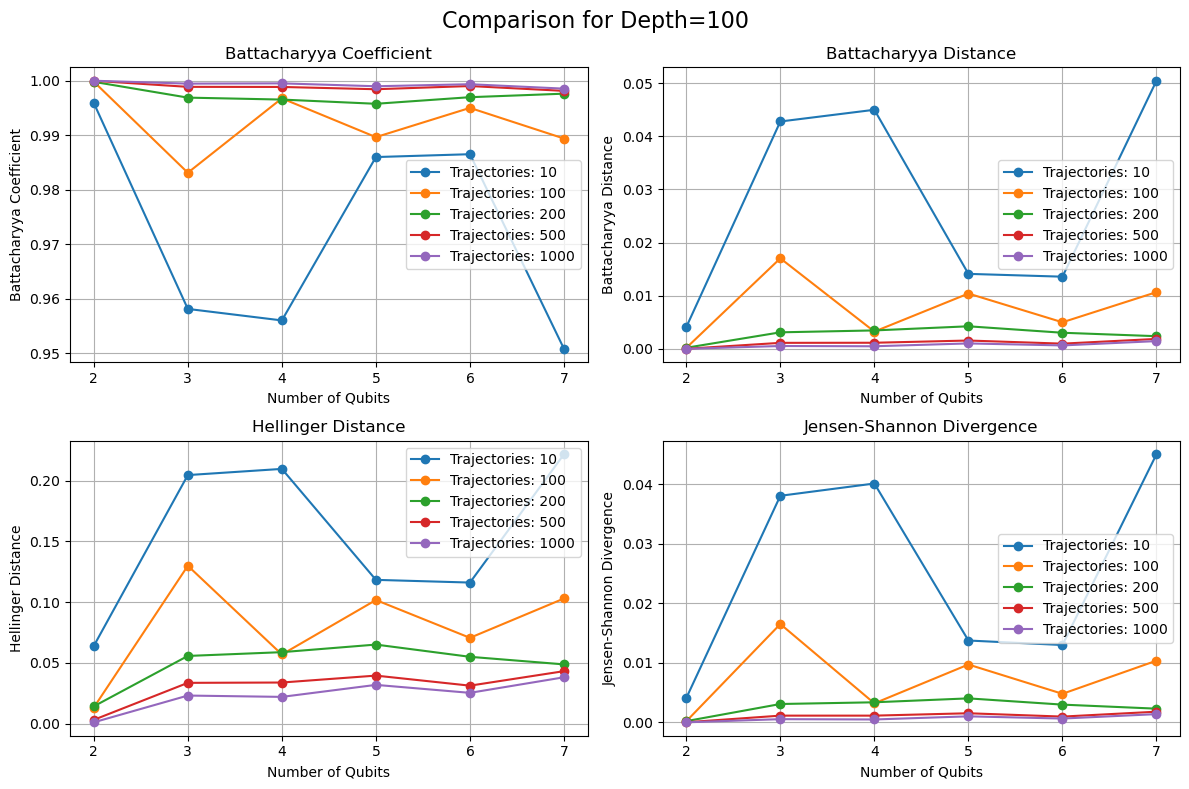

In [10]:
plot_metrics([mcwf_10t_results, mcwf_100t_results, mcwf_200t_results, mcwf_500t_results, mcwf_1000t_results], [10, 100, 200, 500, 1000])